# MedLeaves- Medicinal Plant Leaves Dataset (from Kaggle):

1. Dataset for Identification and Segmentation of Medicinal Plant Leaves- 30classes

2. Cropped Dataset is for DenseNet Class verifier training

3. MedLeaves Dataset is for Yolo training

https://www.kaggle.com/datasets/mirlab/medleaves-medicinal-plant-leaves-dataset

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# FIRST EXECUTION (skip it if you've already done it):

In [ ]:
# project working directory
!mkdir /content/drive/MyDrive/med_plants_classifier

## 1. Virtual environment

In [ ]:
!pip install -q virtualenv

In [ ]:
# creating virtual environment
!virtualenv /content/drive/MyDrive/colab_env

In [ ]:
# activate environment and install packages
!source /content/drive/MyDrive/colab_env/bin/activate; pip install -q pytorch-lightning kaggle

## 2. Loading dataset using Kaggle API

In [ ]:
# for loading private kaggle.json file with API token
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# allow reading and writing
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s "MedLeaves- Medicinal Plant Leaves Dataset"

In [ ]:
!kaggle datasets download -d "mirlab/medleaves-medicinal-plant-leaves-dataset"

In [ ]:
%%capture
!unzip /content/medleaves-medicinal-plant-leaves-dataset.zip -d /content/drive/MyDrive/med_plants_classifier

In [ ]:
!rm medleaves-medicinal-plant-leaves-dataset.zip

# PREPARING

In [3]:
# add virtual environment to system path
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

In [4]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from torchvision.models.densenet import DenseNet, DenseNet121_Weights
import yaml

In [ ]:
torch.random.manual_seed(42)
pl.seed_everything(42)

In [3]:
WORK_DIR = pathlib.Path('/content/drive/MyDrive/med_plants_classifier')
DATASET_DIR = WORK_DIR / 'CroppedMedLeaves/CroppedMedLeaves'
TRAIN_DIR = DATASET_DIR / 'train'
VAL_DIR = DATASET_DIR / 'valid'
TEST_DIR = DATASET_DIR / 'test'
LOG_DIR = WORK_DIR / 'logs'
MODELS_DIR = WORK_DIR / 'models'
DATA_YAML_DIR = WORK_DIR / 'MedLeaves/MedLeaves/data.yaml'

In [ ]:
train_images_paths = [p.resolve() for p in TRAIN_DIR.glob('**/*') if p.suffix in {'.png', '.jpg', '.jpeg'}]
val_images_paths = [p.resolve() for p in VAL_DIR.glob('**/*') if p.suffix in {'.png', '.jpg', '.jpeg'}]
test_images_paths = [p.resolve() for p in TEST_DIR.glob('**/*') if p.suffix in {'.png', '.jpg', '.jpeg'}]
all_images_paths = train_images_paths + val_images_paths + test_images_paths

print(f'train images count: {len(train_images_paths)}', \
      f'val images count: {len(val_images_paths)}', \
      f'test images count: {len(test_images_paths)}', \
      f'total: {len(all_images_paths)}', sep='\n')

# Augmentations

In [7]:
# pytorch lightning works only with named arguments and numpy array
class Transform:
    def __init__(self, transform: A.Compose):
        self.transform = transform

    def __call__(self, image, *args, **kwargs):
        return self.transform(image=np.array(image))

In [19]:
class RotateToVertical(ImageOnlyTransform):
    def apply(self, img: np.ndarray, **params) -> np.ndarray:
        if img.shape[0] < img.shape[1]:
            return cv2.transpose(img)
        return img

# values for A.Normalize from https://pytorch.org/hub/pytorch_vision_densenet/
train_transform = A.Compose(
    [
        RotateToVertical(p=1.0),
        A.Resize(height=320, width=180, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0,
                    p=1.0),
        ToTensorV2(transpose_mask=False, p=1.0),
    ]
)

val_transform = A.Compose(
    [
        RotateToVertical(p=1.0),
        A.Resize(height=320, width=180, p=1.0),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0,
                    p=1.0),
        ToTensorV2(transpose_mask=False, p=1.0),
    ]
)

# Training model

In [9]:
class ImgDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size,
                 train_root,
                 val_root,
                 test_root,
                 train_transform,
                 val_transform):

        super().__init__()
        self.batch_size = batch_size
        self.train_root = train_root
        self.val_root = val_root
        self.test_root = test_root
        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        self.train_set = ImageFolder(root=self.train_root, transform=Transform(self.train_transform))
        self.val_set = ImageFolder(root=self.val_root, transform=Transform(self.val_transform))
        self.test_set = ImageFolder(root=self.test_root, transform=Transform(self.val_transform))

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False)

In [10]:
class DenseNetClassifier(pl.LightningModule):
    def __init__(self, in_channels, out_classes, eta):
        super().__init__()
        self.save_hyperparameters()

        # pretrained
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=DenseNet121_Weights.IMAGENET1K_V1)
        self.criterion = nn.CrossEntropyLoss()

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.metrics = {'accuracy': Accuracy(task='multiclass', num_classes=out_classes).to(device)}

        self.preds_stage = {"train": {"loss": [], "accuracy":[]},
                        "valid": {"loss": [], "accuracy":[]},
                        "test": {"loss": [], "accuracy":[]}}

    def forward(self, x):
        return self.model(x)

    # operations with each batch
    def shared_step(self,
                    sample,
                    stage):

        x, y = sample
        logits = self.forward(x['image'].to(torch.float32))

        # get index of maximum value (0 axis - batch, 1 - channel)
        preds = torch.argmax(logits, 1)

        loss = self.criterion(logits, y.to(torch.int64))

        self.preds_stage[stage]['loss'].append(loss.detach().cpu())
        self.preds_stage[stage]['accuracy'].append(self.metrics["accuracy"](preds, y).detach().cpu())
        return loss

    # common operations for each stage
    def shared_epoch_end(self, stage):
        loss = self.preds_stage[stage]['loss']
        loss = torch.stack(loss)
        loss = np.mean([x.item() for x in loss])

        acc = self.preds_stage[stage]['accuracy']
        acc = torch.stack(acc)
        acc = np.mean([x.item() for x in acc])

        # for logs
        metrics = {
            f'{stage}_loss': loss,
            f'{stage}_acc': acc,
        }

        self.log_dict(metrics, prog_bar=True)

        self.preds_stage[stage]['loss'].clear()
        self.preds_stage[stage]['accuracy'].clear()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.eta)

        scheduler_dict = {
            # if the specified metric does not change, the learning rate reduces
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                # how many inefficient epochs to wait before reducing the learning rate
                patience=1
            ),
            'interval': 'epoch',
            'monitor': 'valid_loss'
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}

    # steps (use DataLoader to load data for corresponding stage)
    def training_step(self, batch, batch_idx):
        return self.shared_step(sample=batch, stage='train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(sample=batch, stage="valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(sample=batch, stage="test")

    # metrics calculation
    def on_training_epoch_end(self):
        return self.shared_epoch_end(stage="train")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end(stage="valid")

    def on_test_epoch_end(self):
        return self.shared_epoch_end(stage="test")

In [14]:
callbacks = [
    ModelCheckpoint(
        # how to save
        dirpath=MODELS_DIR,
        filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
        # the number of saved models per experiment
        save_top_k=1,
        # by which metric will the weights be selected
        monitor='valid_loss',
        # when the loss is reduced, the weights will be overwritten
        mode='min',
    ),

    LearningRateMonitor(
        # the interval for checking (step - each iteration)
        logging_interval="step"
    ),

    EarlyStopping(
        # the metric that will be checked
        monitor="valid_loss",
        # the minimum step at which stagnation is not counted
        min_delta=1e-2,
        # number of time with no improvement after which training will be stopped
        patience=1,
        # metric must be minimize
        mode="min"
    )
]

In [15]:
logger = TensorBoardLogger(LOG_DIR)

In [16]:
EPOCH = 11
BATCH = 20
ETA = 1e-2

In [ ]:
dm = ImgDataModule(batch_size=BATCH,
                   train_root=TRAIN_DIR,
                   val_root=VAL_DIR,
                   test_root=TEST_DIR,
                   train_transform=train_transform,
                   val_transform=val_transform)

dm.setup()

# the folder names are sorted alphabetically
print(dm.train_set.classes)
num_classes = len(dm.train_set.classes)
print(f'total: {num_classes}')

In [ ]:
model = DenseNetClassifier(in_channels=3, out_classes=num_classes, eta=ETA)

trainer = pl.Trainer(
    max_epochs=EPOCH,
    logger=logger,
    callbacks=callbacks,
)

In [ ]:
trainer.fit(model, dm)

In [24]:
trainer.test(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9970695972442627     │
│         test_loss         │   0.015498736873269081    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.015498736873269081, 'test_acc': 0.9970695972442627}]

# Example

In [ ]:
classifier = DenseNetClassifier.load_from_checkpoint(MODELS_DIR / 'epoch=11_valid_acc=1.00_valid_loss=0.01.ckpt')

In [ ]:
# classes (folder names) are represented as numbers
# human-readable class names are stored in a separate YAML file
# predicted class name can be obtained from the index (class converted to integer)

with open(DATA_YAML_DIR, "r") as f:
  try:
    content = yaml.safe_load(f)
    class_names = content['names']
    print(class_names)
    print(f'total: {len(class_names)}')
  except yaml.YAMLError as exc:
    print(exc)

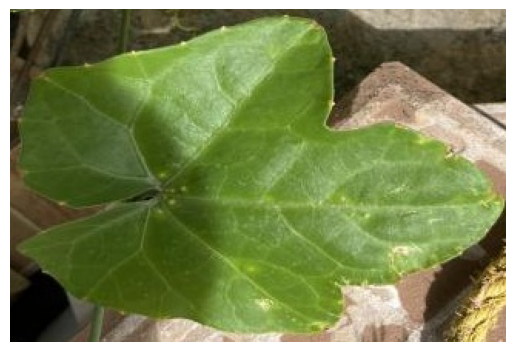

(216, 322, 3)


In [34]:
TEST_IMAGE_PATH = TEST_DIR / '10/2023_09_01_15_44_IMG_1384_JPG_jpg.rf.60a266fd5b40cd2db913b168a37d0e07.jpg_cropped_0_class10.jpg'
example_img = cv2.imread(str(TEST_IMAGE_PATH))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
plt.imshow(example_img)
plt.axis('off')
plt.show()
print(example_img.shape)

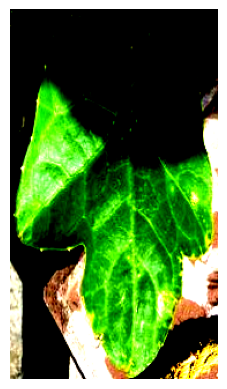

torch.Size([320, 180, 3])


In [35]:
# transformed image
input = val_transform(image=example_img)['image']
plt.imshow(input.permute((1, 2, 0)))
plt.axis('off')
plt.show()
print(input.permute((1, 2, 0)).shape)

In [41]:
classifier.eval()

with torch.no_grad():
    out = classifier(input.unsqueeze(0))
    out_vec = out.numpy()
    idx = np.argmax(out_vec)

class_id = dm.train_set.classes[idx]
print(f'{class_id}. {class_names[int(class_id)]}')

10. Coccinia grandis


In [10]:
# saving the necessary objects to use the model
# class_ids sorted alphabetically (it is necessary for correct predictions of the model)
classes_data = {'class_ids': dm.train_set.classes, 'class_names': class_names}
with open(WORK_DIR / 'classes_data.json', 'w') as file:
    json.dump(classes_data, file)